<font size="6"> Лабораторная работа
"Логистическая регрессия"

Выполнил: Карабалин Руслан ММБ-104

# Введение

Цель работы — предсказание вероятности отклика клиента банка на кампанию нового продукта с помощью логистической регрессии на основе характеристик продукта и клиента

**Постановка задачи:**

Для нового продукта банка необходимо определить круг клиентов, которым будет
совершён телефонный звонок с предложением продукта. Известно, что один звонок
независимо от результата стоит 10 рублей, а каждый успешный звонок приносит банку
100 рублей. Цель -- максимизировать прибыль банка.

Мы имеем задачу классификации клиентов на два класса. Для каждого клиента будем
предсказывать вероятность отклика на кампанию, а затем выберем пороговую
вероятность обзвона. Предсказывать вероятность предлагается с помощью
логистической регрессии. В вашем распоряжении есть выборка из предыдущих звонков,
для каждого из которых имеется вектор признаков (характеристики клиента и продукта),
а также результат звонка.

**Описание переменных:**


Данные банковского клиента:

1. age (числовой)
2. job : тип работы (категориальный: "администратор", "неизвестный", "безработный", "менеджер", "горничная", "предприниматель", "студент", "рабочий", "самозанятый", "пенсионер", "техник","услуги")
3. marital (категориальный: "женат", "разведен", "холост"; примечание: "разведен" означает разведенный или овдовевший)
4. education (категориальный: "неизвестно", "среднее", "начальное", "высшее")
5. default: имеет ли место дефолт по кредиту? (бинарный: "да", "нет")
6. balance: среднегодовой баланс в евро (числовой)
7. housing: есть кредит на жилье? (двоичные значения: "да", "нет")
8. loan: есть личный заем? (двоичные значения: "да", "нет")


Связано с последним контактом в текущей кампании:

9. contact: тип связи с контактом (категориальный: "неизвестно", "телефон", "сотовый")
10. day: последний день контакта в месяце (числовой)
11. month: месяц последнего контакта в году (категориальный: "январь", "февраль", "март", ..., "ноябрь", "декабрь")
12. duration: продолжительность последнего контакта в секундах (числовая) другие признаки:
13. campaign: количество контактов, осуществленных в ходе этой кампании и для данного клиента (числовой, включает последний контакт)
14. pdays: количество дней, прошедших после того, как с клиентом в последний раз связывались в рамках предыдущей кампании (числовой, -1 означает, что с клиентом ранее не связывались)
15. previous: количество контактов, осуществленных до этой кампании и для данного клиента (числовой)
16. poutcome: результат предыдущей маркетинговой кампании (категориальный: "неизвестно", "другое", "неудача", "успех")


Выходная переменная:

17. y: целевая переменная - внес ли клиент срочный депозит? (бинарный: "да", "нет")

Подключение необходимых библиотек:

In [1691]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, recall_score
import matplotlib.pyplot as plt

# Первичная обработка данных

Загрузим данные в переменную data

In [1692]:
data = pd.read_csv('bank.csv', delimiter=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Удалим из данных строки с индексами V, V+2, V+4, V+8,V+16, V+32, V+64, V+128, V+256, V+512, V+1024, V+2048, V+4096,
где V = 32

In [1693]:
V = 32
data.drop(V, inplace=True, axis=0)
for i in range(1, 13):
  data.drop(V + 2**i, inplace=True, axis=0)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Изучим предварительную информацию о выборке при помощи функций head, info, describe:

1. head()

In [1694]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


2. info()

In [1695]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4508 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4508 non-null   int64 
 1   job        4508 non-null   object
 2   marital    4508 non-null   object
 3   education  4508 non-null   object
 4   default    4508 non-null   object
 5   balance    4508 non-null   int64 
 6   housing    4508 non-null   object
 7   loan       4508 non-null   object
 8   contact    4508 non-null   object
 9   day        4508 non-null   int64 
 10  month      4508 non-null   object
 11  duration   4508 non-null   int64 
 12  campaign   4508 non-null   int64 
 13  pdays      4508 non-null   int64 
 14  previous   4508 non-null   int64 
 15  poutcome   4508 non-null   object
 16  y          4508 non-null   object
dtypes: int64(7), object(10)
memory usage: 633.9+ KB


3. describe()

In [1696]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000,4508.000000
mean,41.153949,1417.293478,15.924135,264.105368,2.795918,39.819876,0.543035
std,10.562682,2999.671605,8.250839,260.093162,3.113355,100.217028,1.695257
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1477.000000,21.000000,330.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


С помощью метода data.loc преобразуем категориальную целевую переменную y в бинарную целочисленную переменную

In [1697]:
data.loc[data['y'] == 'yes', 'y'] = 1
data.loc[data['y'] == 'no', 'y'] = 0
data['y'] = data['y'].map(int)
data['y']

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: y, Length: 4508, dtype: int64

В датасете есть признак duration, обозначающий длительность совершённого звонка. Это значение неизвестно до совершения звонка, поэтому не может быть использовано
для предсказания. Удалим эту переменную:

In [1698]:
data.drop('duration', axis=1, inplace=True)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,5,-1,0,unknown,0
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,1,-1,0,unknown,0
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,11,-1,0,unknown,0
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,4,211,3,other,0


Разделим признаки на числовые и категориальные:

In [1699]:
data_numeric = data.select_dtypes(exclude='object')
data_numeric

,age,balance,day,campaign,pdays,previous,y
0,30,1787,19,1,-1,0,0
1,33,4789,11,1,339,4,0
2,35,1350,16,1,330,1,0
3,30,1476,3,4,-1,0,0
4,59,0,5,1,-1,0,0
...,...,...,...,...,...,...,...
4516,33,-333,30,5,-1,0,0
4517,57,-3313,9,1,-1,0,0
4518,57,295,19,11,-1,0,0
4519,28,1137,6,4,211,3,0


In [1700]:
data_categorical = data.select_dtypes(include='object')
data_categorical

,job,marital,education,default,housing,loan,contact,month,poutcome
0,unemployed,married,primary,no,no,no,cellular,oct,unknown
1,services,married,secondary,no,yes,yes,cellular,may,failure
2,management,single,tertiary,no,yes,no,cellular,apr,failure
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
4516,services,married,secondary,no,yes,no,cellular,jul,unknown
4517,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown
4518,technician,married,secondary,no,no,no,cellular,aug,unknown
4519,blue-collar,married,secondary,no,no,no,cellular,feb,other


Применим one-hot кодирование к категориальным данным:

In [1701]:
data_one_hot = pd.get_dummies(data_categorical)
data_one_hot

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4517,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4518,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4519,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Сформируем общую матрицу X признаков, объединив с помощью функции concat переменные data_numeric и data_one_hot, выделив столбец y в отдельную переменную

In [1702]:
y = data_numeric['y']
y

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: y, Length: 4508, dtype: int64

In [1703]:
X = pd.concat([data_numeric.drop('y', axis=1), data_one_hot], axis=1)
X

,age,balance,day,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,1,-1,0,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,33,4789,11,1,339,4,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,35,1350,16,1,330,1,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,30,1476,3,4,-1,0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,59,0,5,1,-1,0,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,30,5,-1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4517,57,-3313,9,1,-1,0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4518,57,295,19,11,-1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4519,28,1137,6,4,211,3,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


Разделим данные на train и test в соотношении 70:30 с помощью функции
train_test_split. Результат запишем в переменные
X_train, X_test, y_train, y_test:

In [1704]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=69)

Выполним нормировку матрицы признаков в обучающей и тестовой выборках с
помощью функции StandardScaler(). Результат
запишишем в переменные X_train_scaled и X_test_scaled:

In [1705]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модель логистической регрессии

Создадим объект класса LogisticRegression и обучим её

In [1706]:
logreg = LogisticRegression(random_state=69)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=69)

Предскажем вероятности принадлежности объектов обучающей выборки к классу 1, используем метод модели predict_proba. Результат запишем в переменные y_train_proba и y_test_proba:

In [1707]:
y_train_proba = logreg.predict_proba(X_train_scaled)[:,1]
y_test_proba = logreg.predict_proba(X_test_scaled)[:,1]
y_train_proba, y_test_proba

(array([0.12444522, 0.02733971, 0.41050178, ..., 0.02222207, 0.02638895,
        0.22403482]),
 array([0.0438047 , 0.07975081, 0.04718408, ..., 0.07850536, 0.10995864,
        0.05658891]))

In [1708]:
y_train_pred = logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)
y_train_pred, y_test_pred

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

Исследуем качество модели на обучающей и тестовой выборках, используя метрику
accuracy, матрицу ошибок и ROC-AUC кривую:

1. метрика accuracy

Для обучающей выборки:

In [1709]:
accuracy_score(y_train, y_train_pred)

0.8941362916006339

Для тестовой выборки:

In [1710]:
accuracy_score(y_test, y_test_pred)

0.8943089430894309

Точность модели логистической регрессии:
- обучающая выьорка - 0,894
- тестовая выборка - 0,894

2. матрица ошибок

Для обучающей выборки:

In [1711]:
cm_tr = confusion_matrix(y_train, y_train_pred, labels=logreg.classes_)
cm_tr

array([[2772,   21],
       [ 313,   49]])

У нас 2772 + 49 верных и 21 + 313 неверных прогнозов

Для тестовой выборки:

In [1712]:
cm_tr = confusion_matrix(y_test, y_test_pred, labels=logreg.classes_)
cm_tr

array([[1189,    8],
       [ 135,   21]])

У нас 1189 + 21 верных и 8 + 135 неверных прогнозов

В ходе построения матрицы ошибок получили следующие данные:
- обучающая выборка: 2821 верных и 334 неверных прогнозов;
- тестовая выборка: 1210 верных и 143 неверных прогнозов.

3. ROC-AUC кривая

Для обучающей выборки:

In [1713]:
roc_auc_score(y_train, y_train_proba)

0.7500548925589428

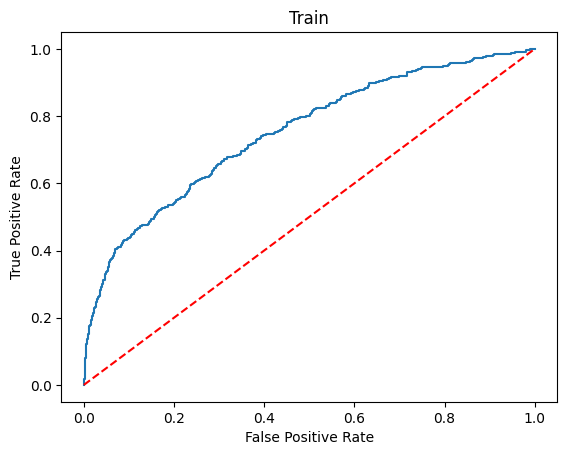

In [1714]:
fpr, tpr, _ = roc_curve(y_train, y_train_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("Train")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

Для тестовой выборки:

In [1715]:
roc_auc_score(y_test, y_test_proba)

0.73530514319988

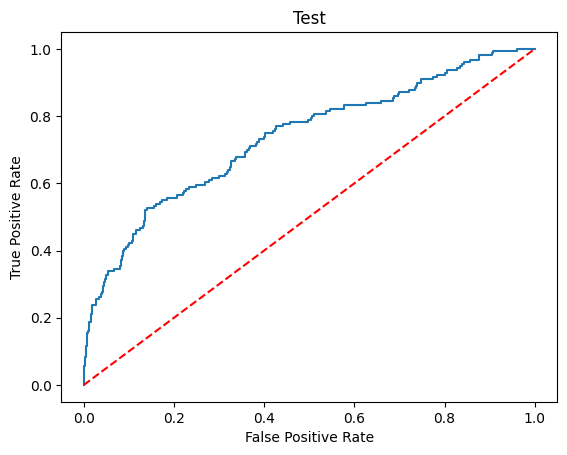

In [1716]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("Test")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

Значения ROC-AUC:
- обучающая выборка - 0,75
- тестовая выборка - 0,735

# Улучшение качества модели

## Итерация 1

Нормируем матрицу X:

In [1717]:
X_scaled = scaler.fit_transform(X)

Обучим модель на нормированной матрице и вычислим предсказанные значения и вероятности принадлежности к классу:

In [1718]:
logreg.fit(X_scaled, y)
y_pred = logreg.predict(X_scaled)
y_proba = logreg.predict_proba(X_scaled)[:,1]

Создадим таблицу Z состоящую из столбца y, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1719]:
Z = pd.DataFrame(y)
Z['proba'] = y_proba
Z['y_pred'] = y_pred
Z

,y,proba,y_pred
0,0,0.282562,0
1,0,0.049590,0
2,0,0.214394,0
3,0,0.037170,0
4,0,0.025455,0
...,...,...,...
4516,0,0.070440,0
4517,0,0.032156,0
4518,0,0.056947,0
4519,0,0.175623,0


Удалим из Z строки с правильно предсказанными классами:

In [1720]:
Z.drop(Z[(Z['y'] == Z['y_pred'])].index, inplace=True)
Z.sort_values('proba', ascending=False, inplace=True)
Z

,y,proba,y_pred
3243,0,0.921004,1
338,0,0.914352,1
657,0,0.894950,1
1186,0,0.865369,1
3370,0,0.851108,1
...,...,...,...
4342,1,0.017438,0
2705,1,0.017340,0
2202,1,0.016482,0
2973,1,0.015916,0


In [1721]:
Z[Z['proba'] > 0.5]

,y,proba,y_pred
3243,0,0.921004,1
338,0,0.914352,1
657,0,0.894950,1
1186,0,0.865369,1
3370,0,0.851108,1
4323,0,0.813078,1
4216,0,0.812107,1
2070,0,0.783009,1
3644,0,0.778876,1
98,0,0.750522,1


In [1722]:
Z

,y,proba,y_pred
3243,0,0.921004,1
338,0,0.914352,1
657,0,0.894950,1
1186,0,0.865369,1
3370,0,0.851108,1
...,...,...,...
4342,1,0.017438,0
2705,1,0.017340,0
2202,1,0.016482,0
2973,1,0.015916,0


Удалим из X и y строки, индексы которых в таблице Z имеют вероятности большие 0,8:

In [1723]:
X1 = X.drop(Z[Z['proba'] > 0.5].index)
y1 = y.drop(Z[Z['proba'] > 0.5].index)

Нормируем матрицу X1:

In [1724]:
X1_scaled = scaler.fit_transform(X1)

Обучим модель на новых данных:

In [1725]:
logreg = logreg.fit(X1_scaled, y1)
y1_proba=logreg.predict_proba(X1_scaled)[:,1]
y1_pred=logreg.predict(X1_scaled)

Метрика accuracy на новых данных:

In [1726]:
accuracy_score(y1, y1_pred)

0.9027995520716685

Точность модели логистической регрессии - 0,895

Матрица ошибок на новых данных:

In [1727]:
cm_tr = confusion_matrix(y1, y1_pred, labels=logreg.classes_)
cm_tr

array([[3920,   27],
       [ 407,  111]])

У нас 3935 + 91 правильных и 48 + 427 неправильных прогнозов

ROC-AUC:

In [1728]:
roc_auc_score(y1, y1_proba)

0.7568756095485257

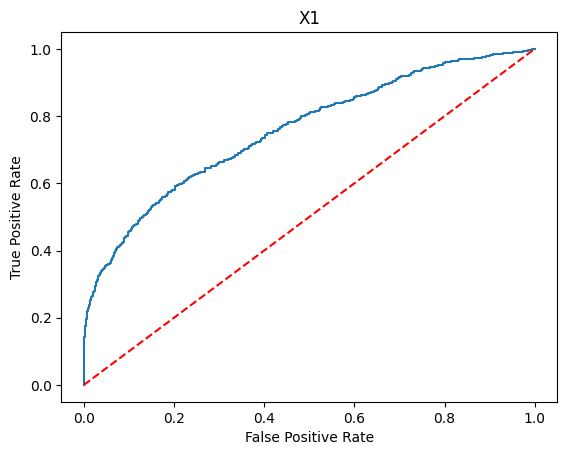

In [1729]:
fpr, tpr, _ = roc_curve(y1, y1_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X1")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,8 из X и y получили:
- Точность модели логистической регрессии 0,895;
- Матрица ошибок содержит 4026 верных и 475 неверных прогнозов;
- AUC=0,75.

In [1730]:
X.shape[0] - X1.shape[0]

43

## Итерация 2

Создадим таблицу Z1 состоящую из столбца y1, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1731]:
Z1 = pd.DataFrame(y1)
Z1['proba'] = y1_proba
Z1['y_pred'] = y1_pred
Z1

,y,proba,y_pred
0,0,0.340864,0
1,0,0.042250,0
2,0,0.220262,0
3,0,0.029439,0
4,0,0.025264,0
...,...,...,...
4516,0,0.064121,0
4517,0,0.033009,0
4518,0,0.057031,0
4519,0,0.175648,0


Удалим из Z1 строки с правильно предсказанными классами:

In [1732]:
Z1.drop(Z1[(Z1['y'] == Z1['y_pred'])].index, inplace=True)
Z1.sort_values('proba', ascending=False, inplace=True)
Z1

,y,proba,y_pred
397,0,0.825154,1
555,0,0.806205,1
658,0,0.801975,1
1083,0,0.797568,1
2188,0,0.781618,1
...,...,...,...
2705,1,0.016699,0
4342,1,0.016469,0
2973,1,0.014606,0
2202,1,0.013590,0


In [1733]:
Z1[Z1['proba'] > 0.5]

,y,proba,y_pred
397,0,0.825154,1
555,0,0.806205,1
658,0,0.801975,1
1083,0,0.797568,1
2188,0,0.781618,1
3270,0,0.765510,1
2699,0,0.749961,1
186,0,0.748008,1
2992,0,0.747058,1
1167,0,0.739176,1


Удалим из X1 и y1 строки, индексы которых в таблице Z1 имеют вероятности большие 0,7:

In [1734]:
X2 = X1.drop(Z1[Z1['proba'] > 0.5].index)
y2 = y1.drop(Z1[Z1['proba'] > 0.5].index)

Нормируем матрицу X2:

In [1735]:
X2_scaled = scaler.fit_transform(X2)

Обучим модель на новых данных:

In [1736]:
logreg = logreg.fit(X2_scaled, y2)
y2_proba=logreg.predict_proba(X2_scaled)[:,1]
y2_pred=logreg.predict(X2_scaled)

Метрика accuracy на новых данных:

In [1737]:
accuracy_score(y2, y2_pred)

0.9067147363677333

Точность модели логистической регрессии - 0,896

Матрица ошибок на новых данных:

In [1738]:
cm_tr = confusion_matrix(y2, y2_pred, labels=logreg.classes_)
cm_tr

array([[3903,   17],
       [ 397,  121]])

У нас 3929 + 96 правильных и 45 + 422 неправильных прогнозов

ROC-AUC:

In [1739]:
roc_auc_score(y2, y2_proba)

0.7619144472460799

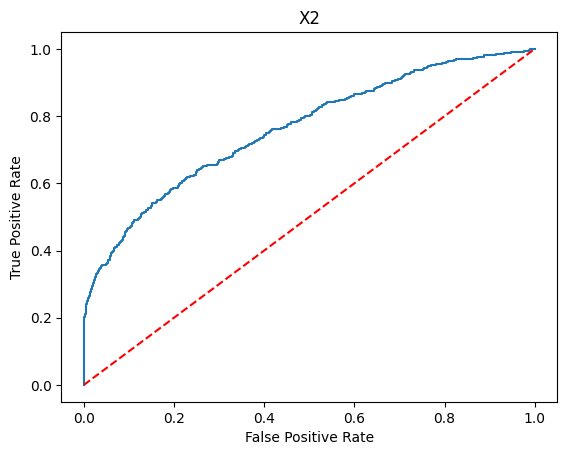

In [1740]:
fpr, tpr, _ = roc_curve(y2, y2_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X2")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,7 из X1 и y1 получили:
- Точность модели логистической регрессии 0,896;
- Матрица ошибок содержит 4025 верных и 467 неверных прогнозов;
- AUC=0,752.

In [1741]:
X1.shape[0] - X2.shape[0]

27

## Итерация 3

Создадим таблицу Z2 состоящую из столбца y2, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1742]:
Z2 = pd.DataFrame(y2)
Z2['proba'] = y2_proba
Z2['y_pred'] = y2_pred
Z2

,y,proba,y_pred
0,0,0.443174,0
1,0,0.039265,0
2,0,0.219817,0
3,0,0.028708,0
4,0,0.027094,0
...,...,...,...
4516,0,0.065118,0
4517,0,0.031794,0
4518,0,0.054547,0
4519,0,0.180251,0


Удалим из Z2 строки с правильно предсказанными классами:

In [1743]:
Z2.drop(Z2[(Z2['y'] == Z2['y_pred'])].index, inplace=True)
Z2.sort_values('proba', ascending=False, inplace=True)
Z2

,y,proba,y_pred
1750,0,0.676996,1
504,0,0.610605,1
2417,0,0.604250,1
3346,0,0.597789,1
3251,0,0.588213,1
...,...,...,...
2705,1,0.019339,0
4342,1,0.015918,0
2973,1,0.014047,0
2202,1,0.013447,0


In [1744]:
Z2[Z2['proba'] > 0.5]

,y,proba,y_pred
1750,0,0.676996,1
504,0,0.610605,1
2417,0,0.604250,1
3346,0,0.597789,1
3251,0,0.588213,1
2454,0,0.584798,1
922,0,0.574545,1
2687,0,0.571837,1
2451,0,0.570755,1
858,0,0.565705,1


Удалим из X2 и y2 строки, индексы которых в таблице Z2 имеют вероятности большие 0,6:

In [1745]:
X3 = X2.drop(Z2[Z2['proba'] > 0.5].index)
y3 = y2.drop(Z2[Z2['proba'] > 0.5].index)

Нормируем матрицу X3:

In [1746]:
X3_scaled = scaler.fit_transform(X3)

Обучим модель на новых данных:

In [1747]:
logreg = logreg.fit(X3_scaled, y3)
y3_proba=logreg.predict_proba(X3_scaled)[:,1]
y3_pred=logreg.predict(X3_scaled)

Метрика accuracy на новых данных:

In [1748]:
accuracy_score(y3, y3_pred)

0.9092965392445148

Точность модели логистической регрессии - 0,901

Матрица ошибок на новых данных:

In [1749]:
cm_tr = confusion_matrix(y3, y3_pred, labels=logreg.classes_)
cm_tr

array([[3897,    6],
       [ 395,  123]])

У нас 3925 + 101 правильных и 25 + 417 неправильных прогнозов

ROC-AUC:

In [1750]:
roc_auc_score(y3, y3_proba)

0.7637749201930601

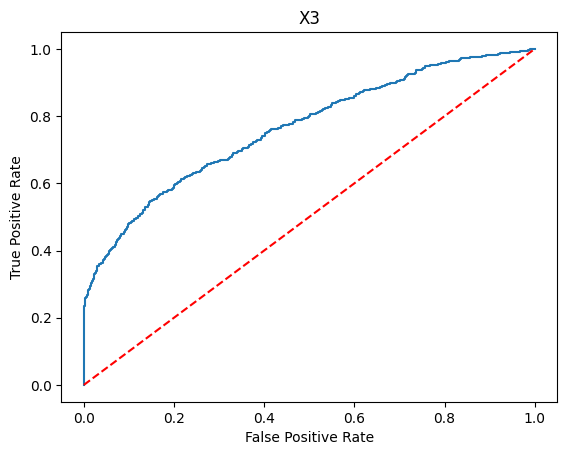

In [1751]:
fpr, tpr, _ = roc_curve(y3, y3_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X3")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,6 из X2 и y2 получили:
- Точность модели логистической регрессии 0,901;
- Матрица ошибок содержит 4026 верных и 442 неверных прогнозов;
- AUC=0,756.

In [1752]:
X2.shape[0] - X3.shape[0]

17

## Итерация 4

Создадим таблицу Z3 состоящую из столбца y3, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1753]:
Z3 = pd.DataFrame(y3)
Z3['proba'] = y3_proba
Z3['y_pred'] = y3_pred
Z3

,y,proba,y_pred
0,0,0.781015,1
1,0,0.037882,0
2,0,0.205357,0
3,0,0.026411,0
4,0,0.028904,0
...,...,...,...
4516,0,0.061175,0
4517,0,0.030911,0
4518,0,0.057482,0
4519,0,0.177788,0


Удалим из Z3 строки с правильно предсказанными классами:

In [1754]:
Z3.drop(Z3[(Z3['y'] == Z3['y_pred'])].index, inplace=True)
Z3.sort_values('proba', ascending=False, inplace=True)
Z3

,y,proba,y_pred
4092,0,0.815048,1
0,0,0.781015,1
3826,0,0.759578,1
3933,0,0.742073,1
4083,0,0.512347,1
...,...,...,...
2705,1,0.019810,0
4342,1,0.016737,0
2973,1,0.013631,0
298,1,0.012600,0


In [1755]:
Z3[Z3['proba'] > 0.5]

,y,proba,y_pred
4092,0,0.815048,1
0,0,0.781015,1
3826,0,0.759578,1
3933,0,0.742073,1
4083,0,0.512347,1
519,0,0.509190,1


Удалим из X3 и y3 строки, индексы которых в таблице Z3 имеют вероятности большие 0,5:

In [1756]:
X4 = X3.drop(Z3[Z3['proba'] > 0.5].index)
y4 = y3.drop(Z3[Z3['proba'] > 0.5].index)

Нормируем матрицу X4:

In [1757]:
X4_scaled = scaler.fit_transform(X4)

Обучим модель на новых данных:

In [1758]:
logreg = logreg.fit(X4_scaled, y4)
y4_proba=logreg.predict_proba(X4_scaled)[:,1]
y4_pred=logreg.predict(X4_scaled)

Метрика accuracy на новых данных:

In [1759]:
accuracy_score(y4, y4_pred)

0.910079275198188

Точность модели логистической регрессии - 0,905

Матрица ошибок на новых данных:

In [1760]:
cm_tr = confusion_matrix(y4, y4_pred, labels=logreg.classes_)
cm_tr

array([[3894,    3],
       [ 394,  124]])

У нас 3908 + 112 правильных и 17 + 406 неправильных прогнозов

ROC-AUC:

In [1761]:
roc_auc_score(y4, y4_proba)

0.7644876813468037

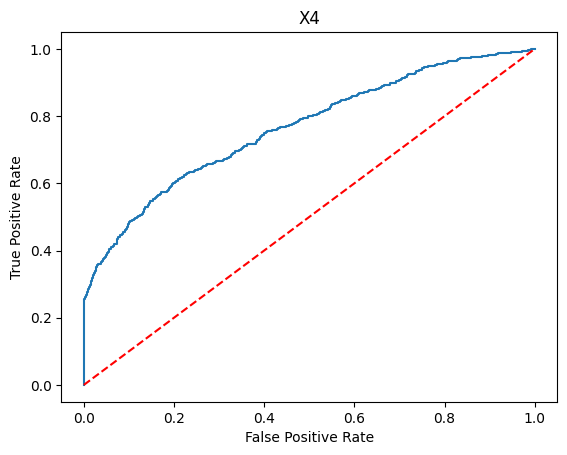

In [1762]:
fpr, tpr, _ = roc_curve(y4, y4_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X4")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,5 из X3 и y3 получили:
- Точность модели логистической регрессии 0,905;
- Матрица ошибок содержит 4020 верных и 423 неверных прогнозов;
- AUC=0,761.

In [1763]:
X3.shape[0] - X4.shape[0]

6

## Итерация 5


Создадим таблицу Z4 состоящую из столбца y4, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1764]:
Z4 = pd.DataFrame(y4)
Z4['proba'] = y4_proba
Z4['y_pred'] = y4_pred
Z4

,y,proba,y_pred
1,0,0.036785,0
2,0,0.197588,0
3,0,0.026039,0
4,0,0.029080,0
5,0,0.257005,0
...,...,...,...
4516,0,0.062611,0
4517,0,0.030715,0
4518,0,0.058616,0
4519,0,0.177300,0


Удалим из Z4 строки с правильно предсказанными классами:

In [1765]:
Z4.drop(Z4[(Z4['y'] == Z4['y_pred'])].index, inplace=True)
Z4.sort_values('proba', ascending=False, inplace=True)
Z4

,y,proba,y_pred
1106,0,0.762670,1
392,0,0.502462,1
1298,0,0.500183,1
1077,1,0.492965,0
4465,1,0.490111,0
...,...,...,...
2705,1,0.019692,0
4342,1,0.015638,0
2973,1,0.013591,0
298,1,0.012734,0


In [1766]:
Z4[Z4['proba'] > 0.5]

,y,proba,y_pred
1106,0,0.762670,1
392,0,0.502462,1
1298,0,0.500183,1


Удалим из X4 и y4 строки, индексы которых в таблице Z4 имеют вероятности большие 0,5:

In [1767]:
X5 = X4.drop(Z4[Z4['proba'] > 0.5].index)
y5 = y4.drop(Z4[Z4['proba'] > 0.5].index)

Нормируем матрицу X5:

In [1768]:
X5_scaled = scaler.fit_transform(X5)

Обучим модель на новых данных:

In [1769]:
logreg = logreg.fit(X5_scaled, y5)
y5_proba=logreg.predict_proba(X5_scaled)[:,1]
y5_pred=logreg.predict(X5_scaled)

Метрика accuracy на новых данных:

In [1770]:
accuracy_score(y5, y5_pred)

0.9111514052583862

Точность модели логистической регрессии - 0,908

Матрица ошибок на новых данных:

In [1771]:
cm_tr = confusion_matrix(y5, y5_pred, labels=logreg.classes_)
cm_tr

array([[3892,    2],
       [ 390,  128]])

У нас 3898 + 120 правильных и 10 + 398 неправильных прогнозов

ROC-AUC:

In [1772]:
roc_auc_score(y5, y5_proba)

0.765580350326113

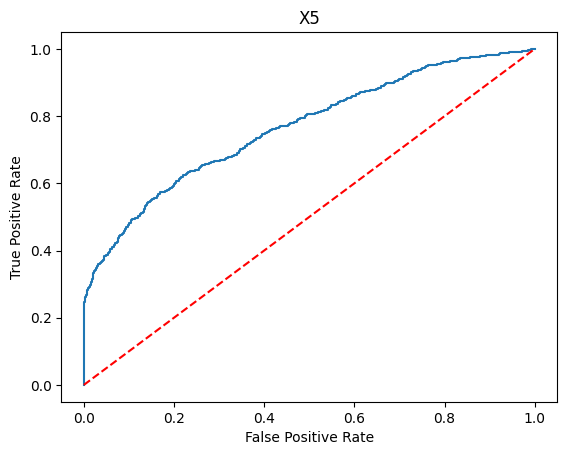

In [1773]:
fpr, tpr, _ = roc_curve(y5, y5_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X5")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,5 из X4 и y4 получили:
- Точность модели логистической регрессии 0,908;
- Матрица ошибок содержит 4018 верных и 408 неверных прогнозов;
- AUC=0,763.

Проверим, что удалили не более 200 строк:

In [1774]:
X4.shape[0] - X5.shape[0]

3

## Итерация 6


Создадим таблицу Z5 состоящую из столбца y5, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1775]:
Z5 = pd.DataFrame(y5)
Z5['proba'] = y5_proba
Z5['y_pred'] = y5_pred
Z5

,y,proba,y_pred
1,0,0.039782,0
2,0,0.203918,0
3,0,0.026946,0
4,0,0.029807,0
5,0,0.252321,0
...,...,...,...
4516,0,0.061607,0
4517,0,0.031437,0
4518,0,0.058024,0
4519,0,0.179456,0


Удалим из Z5 строки с правильно предсказанными классами:

In [1776]:
Z5.drop(Z5[(Z5['y'] == Z5['y_pred'])].index, inplace=True)
Z5.sort_values('proba', ascending=False, inplace=True)
Z5

,y,proba,y_pred
3292,0,0.511790,1
1371,0,0.506020,1
1312,1,0.486768,0
2845,1,0.483571,0
3502,1,0.480419,0
...,...,...,...
2705,1,0.020851,0
4342,1,0.016003,0
2973,1,0.013720,0
298,1,0.012644,0


In [1777]:
Z5[Z5['proba'] > 0.5]

,y,proba,y_pred
3292,0,0.51179,1
1371,0,0.50602,1


Удалим из X5 и y5 строки, индексы которых в таблице Z5 имеют вероятности большие 0,5:

In [1778]:
X6 = X5.drop(Z5[Z5['proba'] > 0.5].index)
y6 = y5.drop(Z5[Z5['proba'] > 0.5].index)

Нормируем матрицу X5:

In [1779]:
X6_scaled = scaler.fit_transform(X6)

Обучим модель на новых данных:

In [1780]:
logreg = logreg.fit(X6_scaled, y6)
y6_proba=logreg.predict_proba(X6_scaled)[:,1]
y6_pred=logreg.predict(X6_scaled)

Метрика accuracy на новых данных:

In [1781]:
accuracy_score(y6, y6_pred)

0.9104308390022676

Точность модели логистической регрессии - 0,91

Матрица ошибок на новых данных:

In [1782]:
cm_tr = confusion_matrix(y6, y6_pred, labels=logreg.classes_)
cm_tr

array([[3886,    6],
       [ 389,  129]])

У нас 4015 правильных и 392 неправильных прогнозов

ROC-AUC:

In [1783]:
roc_auc_score(y6, y6_proba)

0.7659033280821564

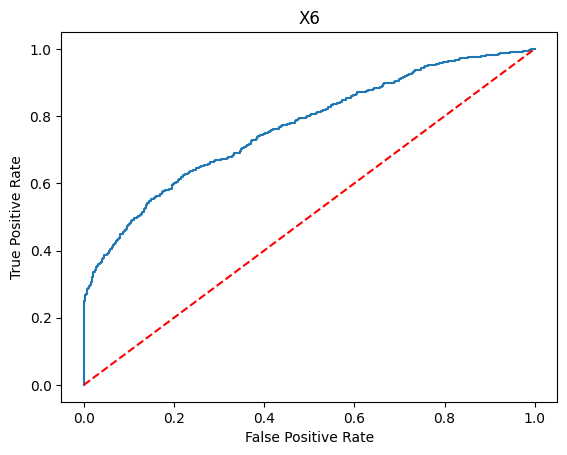

In [1784]:
fpr, tpr, _ = roc_curve(y6, y6_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X6")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,5 из X5 и y5 получили:
- Точность модели логистической регрессии 0,91;
- Матрица ошибок содержит 4015 верных и 392 неверных прогнозов;
- AUC=0,765.

Проверим, что удалили не более 200 строк:

In [1785]:
X5.shape[0] - X6.shape[0]

2

## Итерация 7


Создадим таблицу Z6 состоящую из столбца y6, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1786]:
Z6 = pd.DataFrame(y6)
Z6['proba'] = y6_proba
Z6['y_pred'] = y6_pred
Z6

,y,proba,y_pred
1,0,0.039554,0
2,0,0.204142,0
3,0,0.026969,0
4,0,0.029708,0
5,0,0.250890,0
...,...,...,...
4516,0,0.060855,0
4517,0,0.031339,0
4518,0,0.058152,0
4519,0,0.179429,0


Удалим из Z6 строки с правильно предсказанными классами:

In [1787]:
Z6.drop(Z6[(Z6['y'] == Z6['y_pred'])].index, inplace=True)
Z6.sort_values('proba', ascending=False, inplace=True)
Z6

,y,proba,y_pred
4293,0,0.538263,1
3439,0,0.537592,1
166,0,0.521439,1
797,0,0.521127,1
2922,0,0.520919,1
...,...,...,...
2705,1,0.021143,0
4342,1,0.015638,0
2973,1,0.013558,0
2202,1,0.012493,0


In [1788]:
Z6[Z6['proba'] > 0.5]

,y,proba,y_pred
4293,0,0.538263,1
3439,0,0.537592,1
166,0,0.521439,1
797,0,0.521127,1
2922,0,0.520919,1
569,0,0.503613,1


In [1789]:
Z6[Z6['proba'] > 0.5]

,y,proba,y_pred
4293,0,0.538263,1
3439,0,0.537592,1
166,0,0.521439,1
797,0,0.521127,1
2922,0,0.520919,1
569,0,0.503613,1


Удалим из X6 и y6 строки, индексы которых в таблице Z6 имеют вероятности большие 0,2:

In [1790]:
X7 = X6.drop(Z6[Z6['proba'] > 0.5].index)
y7 = y6.drop(Z6[Z6['proba'] > 0.5].index)

Нормируем матрицу X7:

In [1791]:
X7_scaled = scaler.fit_transform(X7)

Обучим модель на новых данных:

In [1792]:
logreg = logreg.fit(X7_scaled, y7)
y7_proba=logreg.predict_proba(X7_scaled)[:,1]
y7_pred=logreg.predict(X7_scaled)

Метрика accuracy на новых данных:

In [1793]:
accuracy_score(y7, y7_pred)

0.9109900090826522

Точность модели логистической регрессии - 0,91

Матрица ошибок на новых данных:

In [1794]:
cm_tr = confusion_matrix(y7, y7_pred, labels=logreg.classes_)
cm_tr

array([[3880,    6],
       [ 386,  132]])

У нас 4012 правильных и 392 неправильных прогнозов

ROC-AUC:

In [1795]:
roc_auc_score(y7, y7_proba)

0.7667679443284178

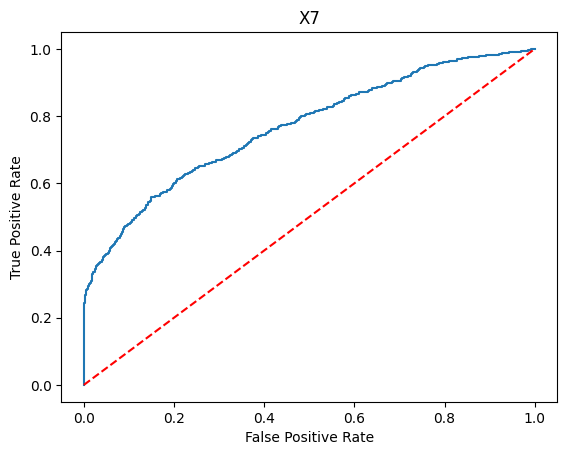

In [1796]:
fpr, tpr, _ = roc_curve(y7, y7_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X7")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,5 из X6 и y6 получили:
- Точность модели логистической регрессии 0,91;
- Матрица ошибок содержит 4012 верных и 392 неверных прогнозов;
- AUC=0,768.

Проверим, что удалили не более 200 строк:

In [1797]:
X6.shape[0] - X7.shape[0]

6

## Итерация 8


Создадим таблицу Z7 состоящую из столбца y7, столбца предсказанных значений целевой функции и столбца вероятностей:

In [1798]:
Z7 = pd.DataFrame(y7)
Z7['proba'] = y7_proba
Z7['y_pred'] = y7_pred
Z7

,y,proba,y_pred
1,0,0.039516,0
2,0,0.203005,0
3,0,0.026812,0
4,0,0.029881,0
5,0,0.246524,0
...,...,...,...
4516,0,0.060431,0
4517,0,0.030990,0
4518,0,0.060183,0
4519,0,0.185462,0


Удалим из Z6 строки с правильно предсказанными классами:

In [1799]:
Z7.drop(Z7[(Z7['y'] == Z7['y_pred'])].index, inplace=True)
Z7.sort_values('proba', ascending=False, inplace=True)
Z7

,y,proba,y_pred
1479,0,0.649892,1
4141,0,0.644976,1
1358,0,0.634746,1
3410,0,0.615982,1
3877,0,0.585070,1
...,...,...,...
886,1,0.021853,0
4342,1,0.017048,0
2973,1,0.013814,0
298,1,0.013670,0


In [1800]:
Z7[Z7['proba'] > 0.5]

,y,proba,y_pred
1479,0,0.649892,1
4141,0,0.644976,1
1358,0,0.634746,1
3410,0,0.615982,1
3877,0,0.585070,1
884,0,0.561485,1


Удалим из X7 и y7 строки, индексы которых в таблице Z7 имеют вероятности большие 0,2:

In [1801]:
X8 = X7.drop(Z7[Z7['proba'] > 0.5].index)
y8 = y7.drop(Z7[Z7['proba'] > 0.5].index)

Нормируем матрицу X8:

In [1802]:
X8_scaled = scaler.fit_transform(X8)

Обучим модель на новых данных:

In [1803]:
logreg = logreg.fit(X8_scaled, y8)
y8_proba=logreg.predict_proba(X8_scaled)[:,1]
y8_pred=logreg.predict(X8_scaled)

Метрика accuracy на новых данных:

In [1804]:
accuracy_score(y8, y8_pred)

0.9120054570259208

Точность модели логистической регрессии - 0,927

Матрица ошибок на новых данных:

In [1805]:
cm_tr = confusion_matrix(y8, y8_pred, labels=logreg.classes_)
cm_tr

array([[3879,    1],
       [ 386,  132]])

У нас 4011 правильных и 387 неправильных прогнозов

ROC-AUC:

In [1806]:
roc_auc_score(y8, y8_proba)

0.7675620944950842

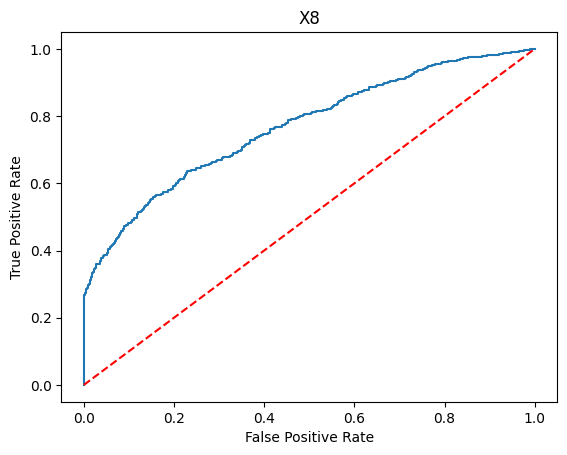

In [1807]:
fpr, tpr, _ = roc_curve(y8, y8_proba, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("X8")
plt.plot([0, 1], [0, 1], '--r')
plt.show()

При удалении значений с вероятностью принятия неверного решения более 0,5 из X7 и y7 получили:
- Точность модели логистической регрессии 0,912;
- Матрица ошибок содержит 4011 верных и 387 неверных прогнозов;
- AUC=0,768.

Проверим, что удалили не более 200 строк:

In [1808]:
X7.shape[0] - X8.shape[0]

6

## Итог

При улучшении качеств модели из итераций мы удаляли значения с вероятностью принятия решения более 0,5.

Точность модели для каждой итерации:
1. 0,895
2. 0,896
3. 0,901
4. 0,905
5. 0,908
6. 0,91
7. 0,91
8. 0,912



Матрица ошибок содержит верных/неверных прогнозов для каждой итерации:
1. 4026/475
2. 4025/467
3. 4026/442
4. 4020/423
5. 4018/408
6. 4015/395
7. 4012/392
8. 4011/387

Значение ROC-AUC для каждой итерации:
1. 0,75
2. 0,752
3. 0,756
4. 0,761
5. 0,763
6. 0,765
7. 0,768
8. 0,768

Количество удалённых строк на каждой итерации:
1. 43
2. 27
3. 17
4. 6
5. 3
6. 2
7. 6
8. 6

Всего удалили - 110 строк

Попытки улучшения модели привели к незначительному увеличению точности, примерно на 1,7%

# Заключение

Цель работы заключалась в предсказании отклика на рекламную кампанию. Цель была достигнута.

Использованные пакеты: numpy, pandas, matplotlib, sklearn.

При подготовке данных была изучена предварительная информация о выборке.Выполнено кодирование целевой переменной. Категориальные признаки заменены бинарными числовыми с помощью их one-hot кодирования. Выборка разделена на обучающую и тестовую в отношении 70:30. Произведена нормировка числовых признаков. Создана и обучена модель логистической регрессии. Качества модели исследованы с помощью метрик accuracy (точность), матрицы ошибок и ROC-кривой. Точность модели составила 0,894 и 0,894 на обучающей и тестовой выборках соответственно. Матрица ошибок содержит:
- для обучающей выборки: 2821 верных и 334 неверных прогнозов.
- для тестовой выборки: 1210 верных и 143 неверных прогнозов.

Значение ROC-AUC = 0,75 и ROC-AUC = 0,753 на обучающей и тестовой выборках соответственно.

Попытки улучшения модели привели к увеличению точности на 1,7%, путем удаления 82 строк данных с наибольшими значениями вероятности предсказания неверного прогноза, точность модели составила 0,908, матрица ошибок содержит 4018 верных и 408 неверных прогнозов, ROC-AUC=0,763.

В результате работы получили модель предсказания ответа на рекламную кампанию, и увеличили точность предсказывающей модели примерно на 1,7%.